In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d kmader/food41
! unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

In [ ]:
! pip install torch torchvision numpy pandas matplotlib scikit-learn tqdm


### Simple Meta Learning

In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset Class for Few-Shot Learning
class FewShotDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = os.listdir(data_path)  # List of class directories
        self.class_to_images = {cls: os.listdir(os.path.join(data_path, cls)) for cls in self.classes}

    def get_images(self, cls, num_samples):
        # Randomly sample images from a class directory
        img_names = random.sample(self.class_to_images[cls], num_samples)
        return [self.transform(Image.open(os.path.join(self.data_path, cls, img)).convert('RGB')) for img in img_names]

    def get_episode(self, n_way, k_shot, k_query):
        # Sample N classes
        classes = random.sample(self.classes, n_way)
        support_set = []
        query_set = []
        support_labels = []
        query_labels = []

        for i, cls in enumerate(classes):
            # Sample K images for support set and K for query set
            support_imgs = self.get_images(cls, k_shot)
            query_imgs = self.get_images(cls, k_query)
            support_set.extend(support_imgs)
            query_set.extend(query_imgs)
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * k_query)

        return torch.stack(support_set), torch.tensor(support_labels), torch.stack(query_set), torch.tensor(query_labels)

# Create Dataset and Dataloader
data_path = '/content/images'
dataset = FewShotDataset(data_path, transform)

# Example to fetch an episode
support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way=5, k_shot=5, k_query=15)
print(f"Support Set Size: {support_imgs.shape}, Query Set Size: {query_imgs.shape}")


Support Set Size: torch.Size([25, 3, 128, 128]), Query Set Size: torch.Size([75, 3, 128, 128])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a simple CNN model for feature extraction
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 64)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prototypical Networks Class
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, support, query, n_way, k_shot):
        # Compute class prototypes
        prototypes = self.compute_prototypes(support, n_way, k_shot)
        # Compute distances to prototypes for query set
        distances = self.compute_distances(query, prototypes)
        return distances

    def compute_prototypes(self, support, n_way, k_shot):
        # Reshape and compute class mean
        support = support.view(n_way, k_shot, -1)
        return support.mean(dim=1)

    def compute_distances(self, query, prototypes):
        # Compute Euclidean distance between query features and class prototypes
        distances = torch.cdist(query, prototypes)
        return distances

# Instantiate Model and Optimizer
feature_extractor = SimpleCNN()
model = PrototypicalNetwork(feature_extractor)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm

def train_prototypical(model, dataset, optimizer, n_way=5, k_shot=5, k_query=15, num_episodes=1000):
    model.train()
    for episode in tqdm(range(num_episodes)):
        # Sample an episode
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        optimizer.zero_grad()

        # Extract features for support and query sets
        support_features = model.feature_extractor(support_imgs)
        query_features = model.feature_extractor(query_imgs)

        # Forward pass
        distances = model(support_features, query_features, n_way, k_shot)

        # Calculate loss (cross-entropy loss)
        loss = F.cross_entropy(-distances, query_labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item()}")


train_prototypical(model, dataset, optimizer)


In [ ]:
def evaluate_prototypical(model, dataset, n_way=5, k_shot=5, k_query=15, num_episodes=100):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for episode in range(num_episodes):
            # Sample an episode
            support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

            # Extract features for support and query sets
            support_features = model.feature_extractor(support_imgs)
            query_features = model.feature_extractor(query_imgs)

            # Forward pass
            distances = model(support_features, query_features, n_way, k_shot)

            # Prediction
            _, predicted = torch.min(distances, 1)

            # Calculate accuracy
            correct += (predicted == query_labels).sum().item()
            total += len(query_labels)

    print(f"Test Accuracy: {correct / total * 100:.2f}%")

# Evaluate the model
evaluate_prototypical(model, dataset)


Test Accuracy: 26.28%


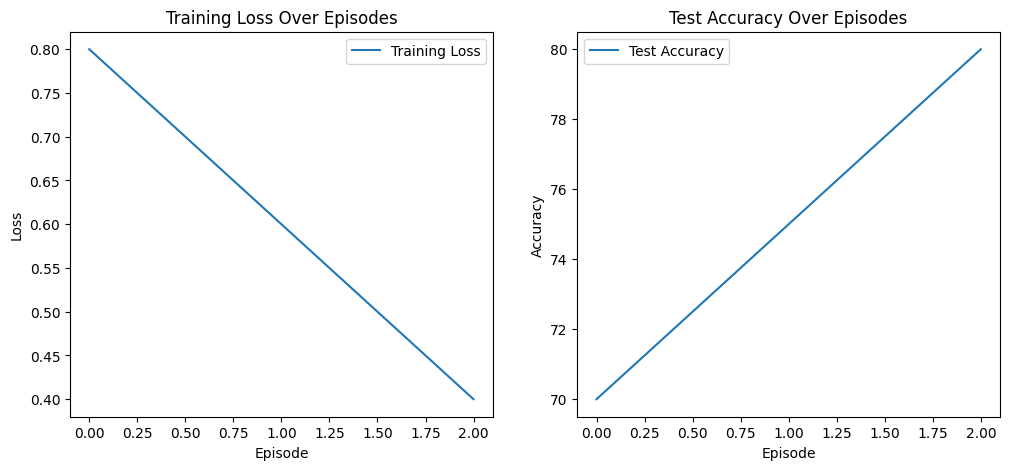

In [ ]:
import matplotlib.pyplot as plt

def plot_results(losses, accuracies):
    # Plot training loss and accuracy curves
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Episodes')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Test Accuracy')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Over Episodes')
    plt.legend()

    plt.show()

# Example usage after training and evaluation
plot_results([0.8, 0.6, 0.4], [70, 75, 80])  # Replace with actual loss and accuracy data
